<h1>导入数据</h1>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from time import strftime, localtime

<h1>数据处理</h1>

<h2>数据预处理</h2>

<h3>conf_info数据预处理</h3>

In [2]:
cons_info = pd.read_csv("../data/训练组_比特币挖矿_档案明细（20211220）.csv", index_col=0, quotechar='"', encoding="gbk")
cons_info

,ID,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CANCEL_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,TMP_DATE,IS_FLAG
,,,,,,,,,,,,,,
1,329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
2,329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
3,329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
4,329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
5,329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,NaN,240.0,2005/6/18,非临时用电,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8836,2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/2 16:12:00,NaN,120.0,2019/12/2 16:12:00,非临时用电,NaN,0
8837,2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,NaN,2019/12/3 16:33:00,NaN,120.0,2019/12/3 16:33:00,非临时用电,NaN,0
8838,2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/18 14:42:00,NaN,120.0,2019/12/18 14:42:00,非临时用电,NaN,0


In [3]:
cons_info = cons_info.set_index("ID").drop(columns=["CANCEL_DATE", "TMP_DATE"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005/6/18,240.0,2005/6/18,非临时用电,0
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/2 16:12:00,120.0,2019/12/2 16:12:00,非临时用电,0
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,NaN,2019/12/3 16:33:00,120.0,2019/12/3 16:33:00,非临时用电,0
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019/12/18 14:42:00,120.0,2019/12/18 14:42:00,非临时用电,0


In [4]:
cons_info["BUILD_DATE"] = pd.to_datetime(cons_info["BUILD_DATE"])
cons_info["LAST_CHK_DATE"] = pd.to_datetime(cons_info["LAST_CHK_DATE"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,NaN,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,NaN,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0


In [5]:
cons_info["SHIFT_NO"] = cons_info["SHIFT_NO"].fillna(0)
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0


In [6]:
cons_info["now"] = "2021-12-31"
cons_info["now"] = pd.to_datetime(cons_info["now"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG,now
ID,,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0,2021-12-31
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0,2021-12-31
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0,2021-12-31


In [7]:
cons_info["live_days"] = (cons_info["now"] - cons_info["BUILD_DATE"]).map(lambda x: x.days)
cons_info["check_days"] = (cons_info["now"] - cons_info["LAST_CHK_DATE"]).map(lambda x: x.days)
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,IS_FLAG,now,live_days,check_days
ID,,,,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,2005-06-18 00:00:00,240.0,2005-06-18 00:00:00,非临时用电,0,2021-12-31,6040,6040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-02 16:12:00,120.0,2019-12-02 16:12:00,非临时用电,0,2021-12-31,759,759
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,2019-12-03 16:33:00,120.0,2019-12-03 16:33:00,非临时用电,0,2021-12-31,758,758
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,2019-12-18 14:42:00,120.0,2019-12-18 14:42:00,非临时用电,0,2021-12-31,743,743


In [8]:
cons_info = cons_info.drop(columns=["BUILD_DATE", "LAST_CHK_DATE", "now"])
cons_info

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,TMP_NAME,IS_FLAG,live_days,check_days
ID,,,,,,,,,,,
329465205,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,240.0,非临时用电,0,6040,6040
329465245,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,4.0,4.0,1.0,240.0,非临时用电,0,6040,6040
329465357,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,240.0,非临时用电,0,6040,6040
329465360,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,2.0,2.0,1.0,240.0,非临时用电,0,6040,6040
329465439,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,8.0,8.0,1.0,240.0,非临时用电,0,6040,6040
...,...,...,...,...,...,...,...,...,...,...,...
2862711473,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,120.0,非临时用电,0,759,759
2864274650,乡村居民生活用电,交流220V,居民合表电价(不满1千伏）,13.0,13.0,0.0,120.0,非临时用电,0,758,758
2872313739,乡村居民生活用电,交流380V,居民合表电价(不满1千伏）,39.0,39.0,0.0,120.0,非临时用电,0,743,743


In [9]:
cons_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8840 entries, 329465205 to 2529558569
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ELEC_TYPE_NAME  8840 non-null   object 
 1   VOLT_NAME       8840 non-null   object 
 2   PRC_NAME        8840 non-null   object 
 3   CONTRACT_CAP    8840 non-null   float64
 4   RUN_CAP         8840 non-null   float64
 5   SHIFT_NO        8840 non-null   float64
 6   CHK_CYCLE       8838 non-null   float64
 7   TMP_NAME        8840 non-null   object 
 8   IS_FLAG         8840 non-null   int64  
 9   live_days       8840 non-null   int64  
 10  check_days      8840 non-null   int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 828.8+ KB


In [10]:
cons_info = pd.get_dummies(cons_info)
cons_info

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,IS_FLAG,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,ELEC_TYPE_NAME_居民生活用电,ELEC_TYPE_NAME_普通工业,ELEC_TYPE_NAME_非居民照明,ELEC_TYPE_NAME_非工业,VOLT_NAME_交流10kV,VOLT_NAME_交流220V,VOLT_NAME_交流380V,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民合表电价(不满1千伏）,TMP_NAME_非临时用电
ID,,,,,,,,,,,,,,,,,,,,,
329465205,4.0,4.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465245,4.0,4.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465357,8.0,8.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465360,2.0,2.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
329465439,8.0,8.0,1.0,240.0,0,6040,6040,1,0,0,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862711473,39.0,39.0,0.0,120.0,0,759,759,1,0,0,...,0,0,0,0,0,0,1,0,1,1
2864274650,13.0,13.0,0.0,120.0,0,758,758,1,0,0,...,0,0,0,0,0,1,0,0,1,1
2872313739,39.0,39.0,0.0,120.0,0,743,743,1,0,0,...,0,0,0,0,0,0,1,0,1,1


<h3>elec_month数据预处理</h3>

In [11]:
elec_month = pd.read_csv("../data/训练组_比特币挖矿_月用电明细（20211217）.csv")
elec_month

,id,ym,pq_f,pq_g,pq_p,pq_z
0,329769614,202001,615,161,0,776
1,329769614,202002,492,154,-1,645
2,329769614,202003,457,114,1,572
3,329769614,202004,522,171,0,693
4,329769614,202005,519,181,0,700
...,...,...,...,...,...,...
194475,2878334859,202106,107,67,-1,173
194476,2878334859,202107,170,112,1,283
194477,2878334859,202108,102,67,0,169
194478,2878334859,202109,112,65,-1,176


In [12]:
elec_month["ym"] = elec_month["ym"].astype(str)
elec_month

,id,ym,pq_f,pq_g,pq_p,pq_z
0,329769614,202001,615,161,0,776
1,329769614,202002,492,154,-1,645
2,329769614,202003,457,114,1,572
3,329769614,202004,522,171,0,693
4,329769614,202005,519,181,0,700
...,...,...,...,...,...,...
194475,2878334859,202106,107,67,-1,173
194476,2878334859,202107,170,112,1,283
194477,2878334859,202108,102,67,0,169
194478,2878334859,202109,112,65,-1,176


In [13]:
elec_month[["pq_f", "pq_g", "pq_p", "pq_z"]] = elec_month[["pq_f", "pq_g", "pq_p", "pq_z"]] / elec_month[["pq_f", "pq_g", "pq_p", "pq_z"]].max(axis=0)
elec_month

,id,ym,pq_f,pq_g,pq_p,pq_z
0,329769614,202001,0.018825,0.009651,0.000000,0.010450
1,329769614,202002,0.015060,0.009232,-0.000036,0.008686
2,329769614,202003,0.013988,0.006834,0.000036,0.007703
3,329769614,202004,0.015978,0.010251,0.000000,0.009332
4,329769614,202005,0.015886,0.010850,0.000000,0.009426
...,...,...,...,...,...,...
194475,2878334859,202106,0.003275,0.004016,-0.000036,0.002330
194476,2878334859,202107,0.005204,0.006714,0.000036,0.003811
194477,2878334859,202108,0.003122,0.004016,0.000000,0.002276
194478,2878334859,202109,0.003428,0.003896,-0.000036,0.002370


In [14]:
cons_month_result = []
for cons_id in tqdm(cons_info.index):
    df = elec_month[elec_month["id"] == cons_id]
    df1 = df.drop(columns=["id"]).sort_values("ym").drop(columns=["ym"])
    cons_month_result.append(df1.T.values)
cons_month = np.array(cons_month_result)
cons_month.shape

100%|████████████████████████████████████████████████████████████████| 8840/8840 [00:14<00:00, 611.08it/s]


(8840, 4, 22)

<h3>elec_day数据预处理</h3>

In [15]:
elec_day = pd.read_csv("../data/训练组_比特币挖矿_日用电明细（20211217）.csv")
elec_day

,id,rq,kwh,kwh_rap,kwh_pap_r1,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4
0,329449398,2020-01-22 00:00:00,11.77,0.0,0.0,7.40,0.0,4.36
1,329449398,2020-01-23 00:00:00,16.54,0.0,0.0,8.68,0.0,7.86
2,329449398,2020-01-24 00:00:00,10.86,0.0,0.0,5.51,0.0,5.36
3,329449398,2020-01-25 00:00:00,10.91,0.0,0.0,6.48,0.0,4.43
4,329449398,2020-01-26 00:00:00,10.85,0.0,0.0,6.32,0.0,4.52
...,...,...,...,...,...,...,...,...
954564,2878334859,2021-10-05 00:00:00,7.22,NaN,0.0,4.49,0.0,2.73
954565,2878334859,2021-10-06 00:00:00,7.23,NaN,0.0,4.48,0.0,2.74
954566,2878334859,2021-10-07 00:00:00,7.20,NaN,0.0,4.48,0.0,2.73
954567,2878334859,2021-10-08 00:00:00,7.23,NaN,0.0,4.50,0.0,2.73


In [16]:
elec_day[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]] = elec_day[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]] / elec_day[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]].max(axis=0)
elec_day

,id,rq,kwh,kwh_rap,kwh_pap_r1,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4
0,329449398,2020-01-22 00:00:00,0.000367,0.0,0.0,0.000641,0.0,0.000450
1,329449398,2020-01-23 00:00:00,0.000516,0.0,0.0,0.000752,0.0,0.000811
2,329449398,2020-01-24 00:00:00,0.000339,0.0,0.0,0.000478,0.0,0.000553
3,329449398,2020-01-25 00:00:00,0.000340,0.0,0.0,0.000562,0.0,0.000457
4,329449398,2020-01-26 00:00:00,0.000338,0.0,0.0,0.000548,0.0,0.000466
...,...,...,...,...,...,...,...,...
954564,2878334859,2021-10-05 00:00:00,0.000225,NaN,0.0,0.000389,0.0,0.000282
954565,2878334859,2021-10-06 00:00:00,0.000225,NaN,0.0,0.000388,0.0,0.000283
954566,2878334859,2021-10-07 00:00:00,0.000225,NaN,0.0,0.000388,0.0,0.000282
954567,2878334859,2021-10-08 00:00:00,0.000225,NaN,0.0,0.000390,0.0,0.000282


In [17]:
elec_day = elec_day.fillna(0)
elec_day

,id,rq,kwh,kwh_rap,kwh_pap_r1,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4
0,329449398,2020-01-22 00:00:00,0.000367,0.0,0.0,0.000641,0.0,0.000450
1,329449398,2020-01-23 00:00:00,0.000516,0.0,0.0,0.000752,0.0,0.000811
2,329449398,2020-01-24 00:00:00,0.000339,0.0,0.0,0.000478,0.0,0.000553
3,329449398,2020-01-25 00:00:00,0.000340,0.0,0.0,0.000562,0.0,0.000457
4,329449398,2020-01-26 00:00:00,0.000338,0.0,0.0,0.000548,0.0,0.000466
...,...,...,...,...,...,...,...,...
954564,2878334859,2021-10-05 00:00:00,0.000225,0.0,0.0,0.000389,0.0,0.000282
954565,2878334859,2021-10-06 00:00:00,0.000225,0.0,0.0,0.000388,0.0,0.000283
954566,2878334859,2021-10-07 00:00:00,0.000225,0.0,0.0,0.000388,0.0,0.000282
954567,2878334859,2021-10-08 00:00:00,0.000225,0.0,0.0,0.000390,0.0,0.000282


In [18]:
dates = pd.to_datetime(elec_day["rq"].unique()).sort_values()

In [19]:
cons_day_result = []
for cons_id in tqdm(cons_info.index):
    df = elec_day[elec_day["id"] == cons_id].drop(columns=["id"]).sort_values("rq")
    df["rq"] = pd.to_datetime(df["rq"])
    df = df.set_index("rq")
    df = df.reindex(dates).fillna(0)
    cons_day_result.append(df.T.values)
cons_day = np.array(cons_day_result)
cons_day.shape

100%|████████████████████████████████████████████████████████████████| 8840/8840 [00:26<00:00, 339.72it/s]


(8840, 6, 108)

<h2>查看处理好的结果</h2>

<h3>标签</h3>

In [20]:
target = cons_info["IS_FLAG"].values.astype(np.float64)

<h3>统一视图</h3>

In [21]:
cons_info = cons_info.drop(columns=["IS_FLAG"]).values
cons_info.shape

(8840, 20)

<h3>月均电量</h3>

In [22]:
cons_month.shape

(8840, 4, 22)

<h3>日电量</h3>

In [23]:
cons_day.shape

(8840, 6, 108)

<h2>对正样本重复</h2>

In [24]:
cons_info_pos = cons_info[target == 1]
cons_info_pos.shape

(10, 20)

In [25]:
cons_month_pos = cons_month[target == 1]
cons_month_pos.shape

(10, 4, 22)

In [26]:
cons_day_pos = cons_day[target == 1]
cons_day_pos.shape

(10, 6, 108)

<h2>提取负样本</h2>

In [27]:
cons_info_neg = cons_info[target == 0]
cons_month_neg = cons_month[target == 0]
cons_day_neg = cons_day[target == 0]
print(cons_info_neg.shape)
print(cons_month_neg.shape)
print(cons_day_neg.shape)

(8830, 20)
(8830, 4, 22)
(8830, 6, 108)


<h2>合并正负样本</h2>

In [28]:
cons_info = np.concatenate([cons_info_pos, cons_info_neg], axis=0)
cons_month = np.concatenate([cons_month_pos, cons_month_neg], axis=0)
cons_day = np.concatenate([cons_day_pos, cons_day_neg], axis=0)
print(cons_info.shape)
print(cons_month.shape)
print(cons_day.shape)

(8840, 20)
(8840, 4, 22)
(8840, 6, 108)


<h2>重复标签</h2>

In [29]:
target_pos = target[target == 1]
target_neg = target[target == 0]
target_pos = target_pos
target = np.concatenate([target_pos, target_neg], axis=0)
print(target.shape)

(8840,)


<h1>计算向量之间的相似性</h1>

In [30]:
cons_num = 30

<h2>计算用户相似度</h2>

In [31]:
cons_info_part = cons_info[0:cons_num, :]
cons_info_part.shape

(30, 20)

In [32]:
cons_info_similarity = cosine_similarity(cons_info_part)
cons_info_similarity.shape

(30, 30)

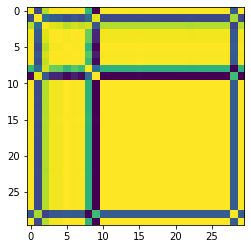

In [33]:
plt.figure(1)
plt.imshow(cons_info_similarity)
plt.show()

<h2>计算月电量相似度</h2>

In [34]:
cons_month_part = cons_month[0:cons_num]
cons_month_part.shape

(30, 4, 22)

In [35]:
month_similarity = np.zeros((cons_num, cons_num))
for i in tqdm(range(cons_num)):
    cons_month_i = cons_month_part[i]
    for j in range(cons_num):
        cons_month_j = cons_month_part[j]
        temp = (cosine_similarity(cons_month_i, cons_month_j) * np.eye(4)).trace()
        month_similarity[i, j] = temp
month_similarity.shape

100%|████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 168.54it/s]


(30, 30)

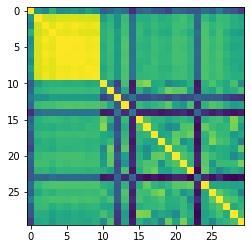

In [36]:
plt.figure(2)
plt.imshow(month_similarity)
plt.show()

In [37]:
month_similarity[1:10, 1:10].min()

3.7517372827124884

<h2>计算日电量相似度</h2>

In [38]:
cons_day_part = cons_day[0:cons_num]
cons_day_part.shape

(30, 6, 108)

In [39]:
day_similarity = np.zeros((cons_num, cons_num))
for i in tqdm(range(cons_num)):
    cons_day_i = cons_day_part[i]
    for j in range(cons_num):
        cons_day_j = cons_day_part[j]
        temp = (cosine_similarity(cons_day_i, cons_day_j) * np.eye(6)).trace()
        day_similarity[i, j] = temp
day_similarity.shape

100%|████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 167.60it/s]


(30, 30)

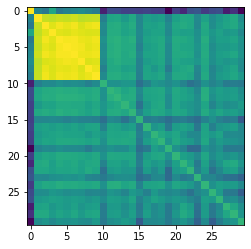

In [40]:
plt.figure(3)
plt.imshow(day_similarity)
plt.show()

In [41]:
day_similarity[1:10, 1:10].min()

3.710532783896906

<h1>处理测试集</h1>

<h2>处理用户数据</h2>

In [42]:
cons_info_test = pd.read_csv("../data/测试组_比特币挖矿_档案明细（20211220）.csv", index_col=0, quotechar='"', encoding="gbk")
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CANCEL_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,TMP_DATE
ID,,,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998/12/1,NaN,24,1998/12/1,非临时用电,NaN
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,1998/12/1,NaN,24,1998/12/1,非临时用电,NaN
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999/4/1,NaN,24,1999/4/1,非临时用电,NaN
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999/3/1,NaN,36,1999/3/1,非临时用电,NaN
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998/12/1,NaN,24,1998/12/1,非临时用电,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,2019/11/8 12:42:00,NaN,120,2019/11/8 12:42:00,非临时用电,NaN
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,NaN,2019/11/18 14:08:00,NaN,120,2019/11/18 14:08:00,非临时用电,NaN
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,NaN,2019/11/18 14:08:00,NaN,120,2019/11/18 14:08:00,非临时用电,NaN


In [43]:
cons_info_test = cons_info_test.drop(columns=["CANCEL_DATE", "TMP_DATE"])
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME
ID,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998/12/1,24,1998/12/1,非临时用电
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,1998/12/1,24,1998/12/1,非临时用电
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999/4/1,24,1999/4/1,非临时用电
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999/3/1,36,1999/3/1,非临时用电
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998/12/1,24,1998/12/1,非临时用电
...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,2019/11/8 12:42:00,120,2019/11/8 12:42:00,非临时用电
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,NaN,2019/11/18 14:08:00,120,2019/11/18 14:08:00,非临时用电
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,NaN,2019/11/18 14:08:00,120,2019/11/18 14:08:00,非临时用电


In [44]:
cons_info_test["BUILD_DATE"] = pd.to_datetime(cons_info_test["BUILD_DATE"])
cons_info_test["LAST_CHK_DATE"] = pd.to_datetime(cons_info_test["LAST_CHK_DATE"])
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME
ID,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999-04-01 00:00:00,24,1999-04-01 00:00:00,非临时用电
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999-03-01 00:00:00,36,1999-03-01 00:00:00,非临时用电
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,NaN,2019-11-08 12:42:00,120,2019-11-08 12:42:00,非临时用电
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,NaN,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,NaN,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电


In [45]:
cons_info_test["SHIFT_NO"] = cons_info_test["SHIFT_NO"].fillna(0)
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME
ID,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999-04-01 00:00:00,24,1999-04-01 00:00:00,非临时用电
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999-03-01 00:00:00,36,1999-03-01 00:00:00,非临时用电
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电
...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,2019-11-08 12:42:00,120,2019-11-08 12:42:00,非临时用电
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电


In [46]:
cons_info_test["now"] = "2021-12-31"
cons_info_test["now"] = pd.to_datetime(cons_info_test["now"])
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,now
ID,,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999-04-01 00:00:00,24,1999-04-01 00:00:00,非临时用电,2021-12-31
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999-03-01 00:00:00,36,1999-03-01 00:00:00,非临时用电,2021-12-31
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31
...,...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,2019-11-08 12:42:00,120,2019-11-08 12:42:00,非临时用电,2021-12-31
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电,2021-12-31
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电,2021-12-31


In [47]:
cons_info_test["live_days"] = (cons_info_test["now"] - cons_info_test["BUILD_DATE"]).map(lambda x: x.days)
cons_info_test["check_days"] = (cons_info_test["now"] - cons_info_test["LAST_CHK_DATE"]).map(lambda x: x.days)
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,BUILD_DATE,CHK_CYCLE,LAST_CHK_DATE,TMP_NAME,now,live_days,check_days
ID,,,,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31,8431,8431
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31,8431,8431
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1999-04-01 00:00:00,24,1999-04-01 00:00:00,非临时用电,2021-12-31,8310,8310
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,1999-03-01 00:00:00,36,1999-03-01 00:00:00,非临时用电,2021-12-31,8341,8341
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,1998-12-01 00:00:00,24,1998-12-01 00:00:00,非临时用电,2021-12-31,8431,8431
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,2019-11-08 12:42:00,120,2019-11-08 12:42:00,非临时用电,2021-12-31,783,783
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电,2021-12-31,773,773
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,0.0,2019-11-18 14:08:00,120,2019-11-18 14:08:00,非临时用电,2021-12-31,773,773


In [48]:
cons_info_test = cons_info_test.drop(columns=["BUILD_DATE", "LAST_CHK_DATE", "now"])
cons_info_test

,ELEC_TYPE_NAME,VOLT_NAME,PRC_NAME,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,TMP_NAME,live_days,check_days
ID,,,,,,,,,,
179406029,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,24,非临时用电,8431,8431
179406030,城镇居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,24,非临时用电,8431,8431
179406094,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,24,非临时用电,8310,8310
179406097,城镇居民生活用电,交流220V,居民生活<1kV(合表),4.0,4.0,1.0,36,非临时用电,8341,8341
179406099,城镇居民生活用电,交流220V,居民生活<1kV(合表),2.0,2.0,1.0,24,非临时用电,8431,8431
...,...,...,...,...,...,...,...,...,...,...
2849971818,乡村居民生活用电,交流220V,居民生活<1kV(合表),12.0,12.0,0.0,120,非临时用电,783,783
2850017469,乡村居民生活用电,交流380V,居民生活<1kV(合表),120.0,120.0,0.0,120,非临时用电,773,773
2850017472,乡村居民生活用电,交流380V,居民生活<1kV(合表),720.0,720.0,0.0,120,非临时用电,773,773


In [49]:
cons_info_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15379 entries, 179406029 to 2852368013
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ELEC_TYPE_NAME  15379 non-null  object 
 1   VOLT_NAME       15379 non-null  object 
 2   PRC_NAME        15379 non-null  object 
 3   CONTRACT_CAP    15379 non-null  float64
 4   RUN_CAP         15379 non-null  float64
 5   SHIFT_NO        15379 non-null  float64
 6   CHK_CYCLE       15379 non-null  int64  
 7   TMP_NAME        15379 non-null  object 
 8   live_days       15379 non-null  int64  
 9   check_days      15379 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 1.3+ MB


In [50]:
cons_info_test = pd.get_dummies(cons_info_test)
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_农业生产用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,ELEC_TYPE_NAME_非居民照明,ELEC_TYPE_NAME_非工业,VOLT_NAME_交流10kV,VOLT_NAME_交流220V,VOLT_NAME_交流380V,VOLT_NAME_交流6kV,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民生活1_10kV(合表),PRC_NAME_居民生活<1kV(合表),TMP_NAME_非临时用电
ID,,,,,,,,,,,,,,,,,,,,,
179406029,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
179406030,12.0,12.0,0.0,24,8431,8431,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
179406094,2.0,2.0,1.0,24,8310,8310,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
179406097,4.0,4.0,1.0,36,8341,8341,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
179406099,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,12.0,12.0,0.0,120,783,783,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2850017469,120.0,120.0,0.0,120,773,773,1,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2850017472,720.0,720.0,0.0,120,773,773,1,0,0,0,...,0,0,0,0,1,0,0,0,1,1


<h2>处理月电量</h2>

<h3>数据准备</h3>

In [51]:
elec_month_test = pd.read_csv("../data/测试组_比特币挖矿_月用电明细（20211217）.csv")
elec_month_test

,id,ym,pq_f,pq_g,pq_p,pq_z
0,179438260,202001,244,111,1,356
1,179438260,202002,217,108,-1,324
2,179438260,202003,280,90,0,370
3,179438260,202004,338,118,1,457
4,179438260,202005,297,120,-1,416
...,...,...,...,...,...,...
338333,2880712108,202106,474,675,0,1149
338334,2880712108,202107,342,881,0,1223
338335,2880712108,202108,293,772,0,1065
338336,2880712108,202109,418,570,-1,987


In [52]:
elec_month_test["ym"] = elec_month_test["ym"].astype(str)
elec_month_test

,id,ym,pq_f,pq_g,pq_p,pq_z
0,179438260,202001,244,111,1,356
1,179438260,202002,217,108,-1,324
2,179438260,202003,280,90,0,370
3,179438260,202004,338,118,1,457
4,179438260,202005,297,120,-1,416
...,...,...,...,...,...,...
338333,2880712108,202106,474,675,0,1149
338334,2880712108,202107,342,881,0,1223
338335,2880712108,202108,293,772,0,1065
338336,2880712108,202109,418,570,-1,987


In [53]:
elec_month_test[["pq_f", "pq_g", "pq_p", "pq_z"]] = elec_month_test[["pq_f", "pq_g", "pq_p", "pq_z"]] / elec_month_test[["pq_f", "pq_g", "pq_p", "pq_z"]].max(axis=0)
elec_month_test

,id,ym,pq_f,pq_g,pq_p,pq_z
0,179438260,202001,0.002546,0.001863,0.000008,0.001541
1,179438260,202002,0.002264,0.001813,-0.000008,0.001402
2,179438260,202003,0.002921,0.001511,0.000000,0.001601
3,179438260,202004,0.003526,0.001981,0.000008,0.001978
4,179438260,202005,0.003099,0.002014,-0.000008,0.001800
...,...,...,...,...,...,...
338333,2880712108,202106,0.004945,0.011329,0.000000,0.004973
338334,2880712108,202107,0.003568,0.014787,0.000000,0.005293
338335,2880712108,202108,0.003057,0.012957,0.000000,0.004609
338336,2880712108,202109,0.004361,0.009567,-0.000008,0.004272


In [54]:
cons_month_result_test = []
for cons_id in tqdm(cons_info_test.index):
    df = elec_month_test[elec_month_test["id"] == cons_id]
    df1 = df.drop(columns=["id"]).sort_values("ym").drop(columns=["ym"])
    cons_month_result_test.append(df1.T.values)
cons_month_test = np.array(cons_month_result_test)
cons_month_test.shape

100%|██████████████████████████████████████████████████████████████| 15379/15379 [00:26<00:00, 570.93it/s]


(15379, 4, 22)

<h3>计算余弦相似度</h3>

In [57]:
cons_month_pos = cons_month[target == 1]
cons_month_result = np.zeros((cons_month_test.shape[0], cons_month_pos.shape[0]))

for i in tqdm(range(cons_month_test.shape[0])):
    cons_month_test_i = cons_month_test[i]
    for j in range(cons_month_pos.shape[0]):
        cons_month_pos_j = cons_month_pos[j]
        temp = (cosine_similarity(cons_month_test_i, cons_month_pos_j) * np.eye(4)).trace()
        cons_month_result[i, j] = temp

cons_month_result.shape

100%|██████████████████████████████████████████████████████████████| 15379/15379 [00:26<00:00, 572.78it/s]


(15379, 10)

<h2>处理日电量</h2>

<h3>处理数据</h3>

In [62]:
elec_day_test = pd.read_csv("../data/测试组_比特币挖矿_日用电明细（20211217）.csv")
elec_day_test

,id,rq,kwh,kwh_rap,kwh_pap_r1,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4
0,179404030,2020-01-22 00:00:00,51.77,NaN,0.0,33.47,0.0,18.31
1,179404030,2020-01-23 00:00:00,73.27,NaN,0.0,51.83,0.0,21.44
2,179404030,2020-01-24 00:00:00,74.90,NaN,0.0,52.20,0.0,22.70
3,179404030,2020-01-25 00:00:00,62.73,NaN,0.0,37.27,0.0,25.45
4,179404030,2020-01-26 00:00:00,64.27,NaN,0.0,41.72,0.0,22.56
...,...,...,...,...,...,...,...,...
1660582,2880712108,2021-10-05 00:00:00,44.85,NaN,0.0,22.14,0.0,22.71
1660583,2880712108,2021-10-06 00:00:00,28.89,NaN,0.0,14.94,0.0,13.95
1660584,2880712108,2021-10-07 00:00:00,51.10,NaN,0.0,27.27,0.0,23.84
1660585,2880712108,2021-10-08 00:00:00,17.96,NaN,0.0,7.19,0.0,10.76


In [63]:
elec_day_test[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]] = elec_day_test[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]] / elec_day_test[["kwh", "kwh_rap", "kwh_pap_r1", "kwh_pap_r2", "kwh_pap_r3", "kwh_pap_r4"]].max(axis=0)
elec_day_test

,id,rq,kwh,kwh_rap,kwh_pap_r1,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4
0,179404030,2020-01-22 00:00:00,0.000228,NaN,0.0,0.000435,0.0,0.000247
1,179404030,2020-01-23 00:00:00,0.000322,NaN,0.0,0.000674,0.0,0.000289
2,179404030,2020-01-24 00:00:00,0.000330,NaN,0.0,0.000679,0.0,0.000306
3,179404030,2020-01-25 00:00:00,0.000276,NaN,0.0,0.000485,0.0,0.000343
4,179404030,2020-01-26 00:00:00,0.000283,NaN,0.0,0.000543,0.0,0.000304
...,...,...,...,...,...,...,...,...
1660582,2880712108,2021-10-05 00:00:00,0.000197,NaN,0.0,0.000288,0.0,0.000306
1660583,2880712108,2021-10-06 00:00:00,0.000127,NaN,0.0,0.000194,0.0,0.000188
1660584,2880712108,2021-10-07 00:00:00,0.000225,NaN,0.0,0.000355,0.0,0.000322
1660585,2880712108,2021-10-08 00:00:00,0.000079,NaN,0.0,0.000094,0.0,0.000145


In [64]:
elec_day_test = elec_day_test.fillna(0)
elec_day_test

,id,rq,kwh,kwh_rap,kwh_pap_r1,kwh_pap_r2,kwh_pap_r3,kwh_pap_r4
0,179404030,2020-01-22 00:00:00,0.000228,0.0,0.0,0.000435,0.0,0.000247
1,179404030,2020-01-23 00:00:00,0.000322,0.0,0.0,0.000674,0.0,0.000289
2,179404030,2020-01-24 00:00:00,0.000330,0.0,0.0,0.000679,0.0,0.000306
3,179404030,2020-01-25 00:00:00,0.000276,0.0,0.0,0.000485,0.0,0.000343
4,179404030,2020-01-26 00:00:00,0.000283,0.0,0.0,0.000543,0.0,0.000304
...,...,...,...,...,...,...,...,...
1660582,2880712108,2021-10-05 00:00:00,0.000197,0.0,0.0,0.000288,0.0,0.000306
1660583,2880712108,2021-10-06 00:00:00,0.000127,0.0,0.0,0.000194,0.0,0.000188
1660584,2880712108,2021-10-07 00:00:00,0.000225,0.0,0.0,0.000355,0.0,0.000322
1660585,2880712108,2021-10-08 00:00:00,0.000079,0.0,0.0,0.000094,0.0,0.000145


In [65]:
dates = pd.to_datetime(elec_day_test["rq"].unique()).sort_values()

In [66]:
cons_day_result_test = []
for cons_id in tqdm(cons_info_test.index):
    df = elec_day_test[elec_day_test["id"] == cons_id].drop(columns=["id"]).sort_values("rq")
    df["rq"] = pd.to_datetime(df["rq"])
    df = df.set_index("rq")
    df = df.reindex(dates).fillna(0)
    cons_day_result_test.append(df.T.values)
cons_day_test = np.array(cons_day_result_test)
cons_day_test.shape

100%|██████████████████████████████████████████████████████████████| 15379/15379 [01:06<00:00, 231.18it/s]


(15379, 6, 108)

<h3>计算余弦相似度</h3>

In [67]:
cons_day_pos = cons_day[target == 1]
cons_day_result = np.zeros((cons_day_test.shape[0], cons_day_pos.shape[0]))

for i in tqdm(range(cons_day_test.shape[0])):
    cons_day_test_i = cons_day_test[i]
    for j in range(cons_day_pos.shape[0]):
        cons_day_pos_j = cons_day_pos[j]
        temp = (cosine_similarity(cons_day_test_i, cons_day_pos_j) * np.eye(6)).trace()
        cons_day_result[i, j] = temp

cons_day_result.shape

100%|██████████████████████████████████████████████████████████████| 15379/15379 [00:29<00:00, 518.49it/s]


(15379, 10)

<h1>数据汇总</h1>

In [73]:
cons_info_test["month_similarity"] = cons_month_result.max(axis=1)
cons_info_test["day_similarity"] = cons_day_result.max(axis=1)
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_农业生产用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,VOLT_NAME_交流10kV,VOLT_NAME_交流220V,VOLT_NAME_交流380V,VOLT_NAME_交流6kV,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民生活1_10kV(合表),PRC_NAME_居民生活<1kV(合表),TMP_NAME_非临时用电,month_similarity,day_similarity
ID,,,,,,,,,,,,,,,,,,,,,
179406029,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,1,0,0,0,0,1,1,3.009593,2.844926
179406030,12.0,12.0,0.0,24,8431,8431,0,0,0,1,...,0,1,0,0,0,0,1,1,1.894341,1.640783
179406094,2.0,2.0,1.0,24,8310,8310,0,0,0,1,...,0,1,0,0,0,0,1,1,2.844499,2.905151
179406097,4.0,4.0,1.0,36,8341,8341,0,0,0,1,...,0,1,0,0,0,0,1,1,2.812777,2.804435
179406099,2.0,2.0,1.0,24,8431,8431,0,0,0,1,...,0,1,0,0,0,0,1,1,2.764479,2.416841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849971818,12.0,12.0,0.0,120,783,783,1,0,0,0,...,0,1,0,0,0,0,1,1,2.983398,1.246030
2850017469,120.0,120.0,0.0,120,773,773,1,0,0,0,...,0,0,1,0,0,0,1,1,0.000000,0.000000
2850017472,720.0,720.0,0.0,120,773,773,1,0,0,0,...,0,0,1,0,0,0,1,1,3.876332,3.772422


In [74]:
cons_info_test["similarity"] = cons_info_test["month_similarity"] * cons_info_test["day_similarity"]
cons_info_test = cons_info_test.sort_values("similarity", ascending=False)
cons_info_test.shape

(15379, 27)

In [75]:
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_农业生产用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,VOLT_NAME_交流220V,VOLT_NAME_交流380V,VOLT_NAME_交流6kV,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民生活1_10kV(合表),PRC_NAME_居民生活<1kV(合表),TMP_NAME_非临时用电,month_similarity,day_similarity,similarity
ID,,,,,,,,,,,,,,,,,,,,,
2005240319,63.0,63.0,0.0,120,2541,2541,0,0,0,1,...,0,1,0,0,0,1,1,3.997366,3.993867,15.964945
2245547063,500.0,500.0,0.0,120,1716,1716,1,0,0,0,...,0,1,0,0,0,1,1,3.997268,3.993245,15.962071
2256064355,417.0,417.0,0.0,12,2064,334,1,0,0,0,...,0,1,0,0,0,1,1,3.996194,3.993081,15.957126
2329827263,68.0,68.0,0.0,120,1802,1802,1,0,0,0,...,0,1,0,0,0,1,1,3.996518,3.991881,15.953624
2245541933,399.0,399.0,0.0,120,1716,1716,1,0,0,0,...,0,1,0,0,0,1,1,3.997259,3.990805,15.952282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314659250,10.0,10.0,0.0,120,1898,1898,1,0,0,0,...,0,1,0,0,0,1,1,0.000000,0.000000,0.000000
2162862043,98.0,98.0,0.0,120,2325,2325,0,0,0,1,...,0,1,0,0,0,1,1,0.000000,0.000000,0.000000
1969616180,12.0,12.0,0.0,120,2820,2820,1,0,0,0,...,1,0,0,0,0,1,1,0.000000,0.000000,0.000000


In [76]:
cons_info_test.iloc[0:30]

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_农业生产用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,VOLT_NAME_交流220V,VOLT_NAME_交流380V,VOLT_NAME_交流6kV,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民生活1_10kV(合表),PRC_NAME_居民生活<1kV(合表),TMP_NAME_非临时用电,month_similarity,day_similarity,similarity
ID,,,,,,,,,,,,,,,,,,,,,
2005240319,63.0,63.0,0.0,120,2541,2541,0,0,0,1,...,0,1,0,0,0,1,1,3.997366,3.993867,15.964945
2245547063,500.0,500.0,0.0,120,1716,1716,1,0,0,0,...,0,1,0,0,0,1,1,3.997268,3.993245,15.962071
2256064355,417.0,417.0,0.0,12,2064,334,1,0,0,0,...,0,1,0,0,0,1,1,3.996194,3.993081,15.957126
2329827263,68.0,68.0,0.0,120,1802,1802,1,0,0,0,...,0,1,0,0,0,1,1,3.996518,3.991881,15.953624
2245541933,399.0,399.0,0.0,120,1716,1716,1,0,0,0,...,0,1,0,0,0,1,1,3.997259,3.990805,15.952282
1390088754,400.0,400.0,0.0,12,4005,305,0,0,0,1,...,0,1,0,0,0,1,1,3.995905,3.991997,15.951640
1566387227,350.0,350.0,0.0,24,3549,1341,1,0,0,0,...,0,1,0,0,0,1,1,3.995744,3.991073,15.947306
2449886074,99.0,99.0,0.0,120,1603,1603,0,0,0,1,...,0,1,0,0,0,1,1,3.996580,3.989563,15.944609
1739980273,30.0,30.0,0.0,120,3027,3027,0,0,0,1,...,0,1,0,0,0,1,1,3.993946,3.991977,15.943744


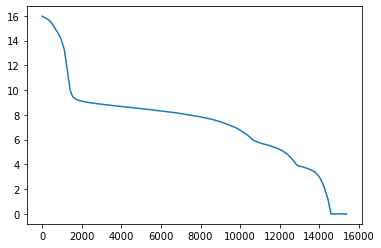

In [77]:
plt.figure(5)
plt.plot(list(range(cons_info_test["similarity"].shape[0])), cons_info_test["similarity"])
plt.show()

In [98]:
cons_info_test["label"] = 0
cons_info_test.loc[(cons_info_test["VOLT_NAME_交流220V"] == 0) & (cons_info_test["similarity"] > 15.5), "label"] = 1
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_农业生产用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,VOLT_NAME_交流380V,VOLT_NAME_交流6kV,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民生活1_10kV(合表),PRC_NAME_居民生活<1kV(合表),TMP_NAME_非临时用电,month_similarity,day_similarity,similarity,label
id,,,,,,,,,,,,,,,,,,,,,
2005240319,63.0,63.0,0.0,120,2541,2541,0,0,0,1,...,1,0,0,0,1,1,3.997366,3.993867,15.964945,1
2245547063,500.0,500.0,0.0,120,1716,1716,1,0,0,0,...,1,0,0,0,1,1,3.997268,3.993245,15.962071,1
2256064355,417.0,417.0,0.0,12,2064,334,1,0,0,0,...,1,0,0,0,1,1,3.996194,3.993081,15.957126,1
2329827263,68.0,68.0,0.0,120,1802,1802,1,0,0,0,...,1,0,0,0,1,1,3.996518,3.991881,15.953624,1
2245541933,399.0,399.0,0.0,120,1716,1716,1,0,0,0,...,1,0,0,0,1,1,3.997259,3.990805,15.952282,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314659250,10.0,10.0,0.0,120,1898,1898,1,0,0,0,...,1,0,0,0,1,1,0.000000,0.000000,0.000000,0
2162862043,98.0,98.0,0.0,120,2325,2325,0,0,0,1,...,1,0,0,0,1,1,0.000000,0.000000,0.000000,0
1969616180,12.0,12.0,0.0,120,2820,2820,1,0,0,0,...,0,0,0,0,1,1,0.000000,0.000000,0.000000,0


In [99]:
cons_info_test.index.name = "id"
cons_info_test

,CONTRACT_CAP,RUN_CAP,SHIFT_NO,CHK_CYCLE,live_days,check_days,ELEC_TYPE_NAME_乡村居民生活用电,ELEC_TYPE_NAME_农业生产用电,ELEC_TYPE_NAME_商业用电,ELEC_TYPE_NAME_城镇居民生活用电,...,VOLT_NAME_交流380V,VOLT_NAME_交流6kV,PRC_NAME_居民合表电价(1-10千伏）,PRC_NAME_居民生活1_10kV(合表),PRC_NAME_居民生活<1kV(合表),TMP_NAME_非临时用电,month_similarity,day_similarity,similarity,label
id,,,,,,,,,,,,,,,,,,,,,
2005240319,63.0,63.0,0.0,120,2541,2541,0,0,0,1,...,1,0,0,0,1,1,3.997366,3.993867,15.964945,1
2245547063,500.0,500.0,0.0,120,1716,1716,1,0,0,0,...,1,0,0,0,1,1,3.997268,3.993245,15.962071,1
2256064355,417.0,417.0,0.0,12,2064,334,1,0,0,0,...,1,0,0,0,1,1,3.996194,3.993081,15.957126,1
2329827263,68.0,68.0,0.0,120,1802,1802,1,0,0,0,...,1,0,0,0,1,1,3.996518,3.991881,15.953624,1
2245541933,399.0,399.0,0.0,120,1716,1716,1,0,0,0,...,1,0,0,0,1,1,3.997259,3.990805,15.952282,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314659250,10.0,10.0,0.0,120,1898,1898,1,0,0,0,...,1,0,0,0,1,1,0.000000,0.000000,0.000000,0
2162862043,98.0,98.0,0.0,120,2325,2325,0,0,0,1,...,1,0,0,0,1,1,0.000000,0.000000,0.000000,0
1969616180,12.0,12.0,0.0,120,2820,2820,1,0,0,0,...,0,0,0,0,1,1,0.000000,0.000000,0.000000,0


In [100]:
cons_info_test[["label"]].to_csv("../data/result20220208-3.csv", index=True)